# Init

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd

import gwadama
import clawdia.plotting

# Load already-computed data

In [2]:
# Strains clean
f = np.load('data/strains_clean.npz')
strains_clean = f['strains']
wave_pos_clean = f['wave_pos']


# Strains injected
f = np.load('data/strains_injected.npz')
strains_injected = f['strains']
lengths_injected = f['lengths']

# Dummy dataset

## Clean

In [3]:
SR = 2048
MAX_LENGTH = 2048

ds = gwadama.SyntheticWaves(
    classes={'SG': 1, 'G': 2, 'RD': 3},
    n_waves_per_class=5,
    wave_parameters_limits={
        'mf0': 100,   'Mf0': 200,
        'mQ': 10,    'MQ': 20,
        'mhrss': 1e-3, 'Mhrss': 1,
        'mT': 0.01,    'MT': 0.5
    },
    max_length=MAX_LENGTH,
    peak_time_max_length=0.5,
    amp_threshold=0.01,
    tukey_alpha=0.1,
    sample_rate=SR,
    random_seed=42
)

In [3]:
ds.metadata

,Class,f0,Q,hrss,duration
0,SG,170.0,13.0,0.376525,0.104492
1,SG,162.0,10.0,0.845020,0.083984
2,SG,169.0,17.0,0.002423,0.137695
3,SG,136.0,13.0,0.602969,0.130859
4,SG,156.0,18.0,0.021392,0.157227
5,G,NaN,NaN,0.004805,0.087891
6,G,NaN,NaN,0.001554,0.254883
7,G,NaN,NaN,0.078522,0.194336
8,G,NaN,NaN,0.011577,0.446289
9,G,NaN,NaN,0.477929,0.209961


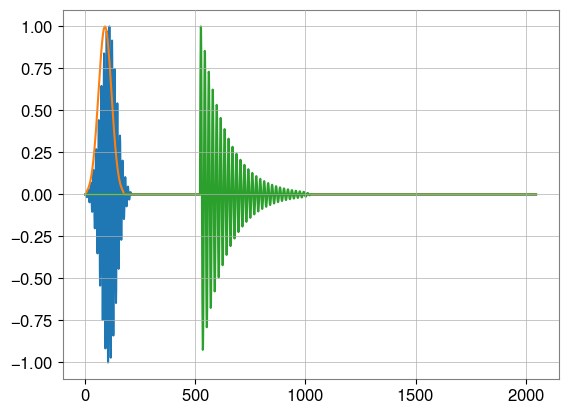

In [15]:
strains, lengths = ds.get_strains_array(length=MAX_LENGTH)

strains /= np.max(np.abs(strains), axis=1, keepdims=True)

fig, ax = plt.subplots()
ax.plot(strains[0])
ax.plot(strains[5])
ax.plot(strains[10])

In [5]:
wave_pos = np.zeros((len(strains), 2), dtype=int)

for i, strain in enumerate(strains):
    wave_pos[i, 0] = np.argmax(np.abs(strain) != 0)
    wave_pos[i, 1] = len(strain) - np.argmax(np.abs(strain[::-1]) != 0)

print(wave_pos)



np.savez_compressed(
    'data/strains_clean.npz',
    strains=strains,
    wave_pos=wave_pos
)

[[   1  213]
 [   1  171]
 [   1  281]
 [   1  267]
 [   1  321]
 [   1  179]
 [   1  521]
 [   1  397]
 [   1  913]
 [   1  429]
 [ 522 1041]
 [ 612 1221]
 [ 262  521]
 [ 339  675]
 [ 336  669]]


## Injected

In [4]:
dsi = gwadama.InjectedSyntheticWaves(
    ds,
    psd=np.loadtxt('data/noise_psd.txt', unpack=True),
    detector='ET',
    noise_length=8*MAX_LENGTH,
    freq_cutoff=20,
    freq_butter_order=5,
    random_seed=42
)

dsi.gen_injections(
    snr=15,
    pad=MAX_LENGTH//2,
    randomize_noise=True,
    random_seed=42,
    injections_per_snr=1,
    verbose=False
)

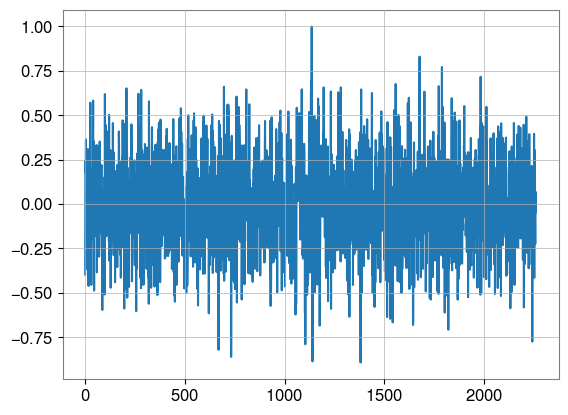

In [7]:
strains_injected, lengths_injected = dsi.get_strains_array()

strains_injected = strains_injected.copy()
strains_injected /= np.max(np.abs(strains_injected), axis=1, keepdims=True)

fig, ax = plt.subplots()
ax.plot(strains_injected[0,:lengths_injected[0]])

In [8]:
np.savez_compressed(
    'data/strains_injected.npz',
    strains=strains_injected,
    lengths=lengths_injected
)

# SPAMS Dictionary

## Initial components

In [3]:
dico = clawdia.dictionaries.DictionarySpams(
    signal_pool=strains_clean.T,
    wave_pos=wave_pos_clean,
    a_length=64,
    d_size=80,
    lambda1=0.1,
    batch_size=1,
    identifier='Test dictionary',
    l2_normed=True,
    allow_allzeros=False,
    patch_min=16,
    random_state=42
)

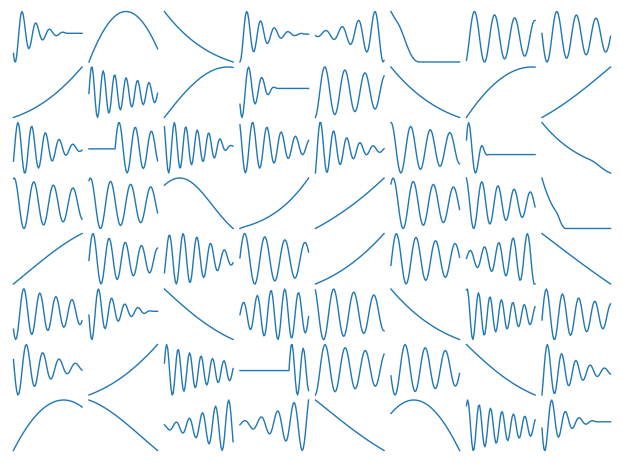

In [10]:
dico_initial = dico.components.copy()

fig = clawdia.plotting.plot_dictionary(dico_initial)

In [11]:
np.save('data/_dictionary_spams/dico_spams_initial.npy', dico_initial)

## Trained components

In [4]:
training_patches = clawdia.lib.extract_patches(
    strains_clean.T,
    patch_size=dico.a_length,
    limits=wave_pos_clean,
    n_patches=100,
    random_state=84,
    l2_normed=True,
    allow_allzeros=False
)

In [13]:
training_patches.shape

(64, 100)

In [5]:
dico.train(
    training_patches,
    n_iter=1000,
    verbose=False,
    threads=1
)

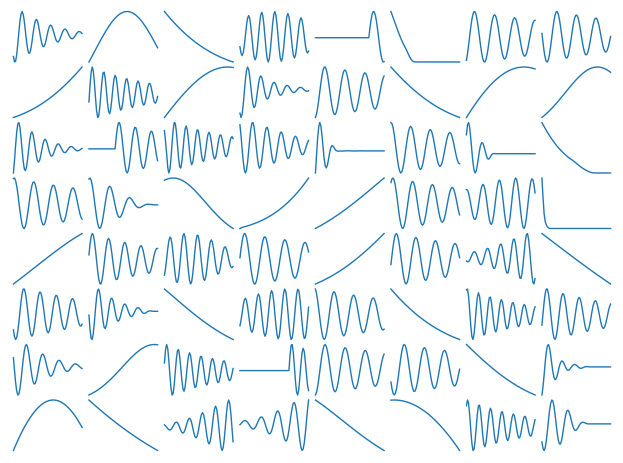

In [15]:
dico_trained = dico.components.copy()

fig = clawdia.plotting.plot_dictionary(dico_trained)

In [16]:
# Must be different.
np.allclose(dico_initial, dico_trained)

False

Ok

In [17]:
np.save('data/_dictionary_spams/dico_spams_trained.npy', dico_trained)

## Denoising reconstruction

In [31]:
# One from each class.
X = strains_injected[[0, 5, 10]]
# X_lim = lengths_injected[[0, 5, 10]]

reconstructions = []
codes = []

for i, x in enumerate(X):
    rec, code = dico.reconstruct(
        # x[:X_lim[i]],
        x,  # Do not crop them so they are equally long.
        sc_lambda=0.5,
        step=2,
        normed=True,
        with_code=True
    )
    reconstructions.append(rec)
    codes.append(code.toarray())

reconstructions = np.array(reconstructions)
codes = np.array(codes)


np.savez_compressed(
    'data/_dictionary_spams/reconstructions_A.npz',
    input=X,
    target_reconstructions=reconstructions,
    target_codes=codes
)

In [28]:
print(reconstructions.shape)
print(codes.shape)

(3, 3270)
(3, 80, 1604)


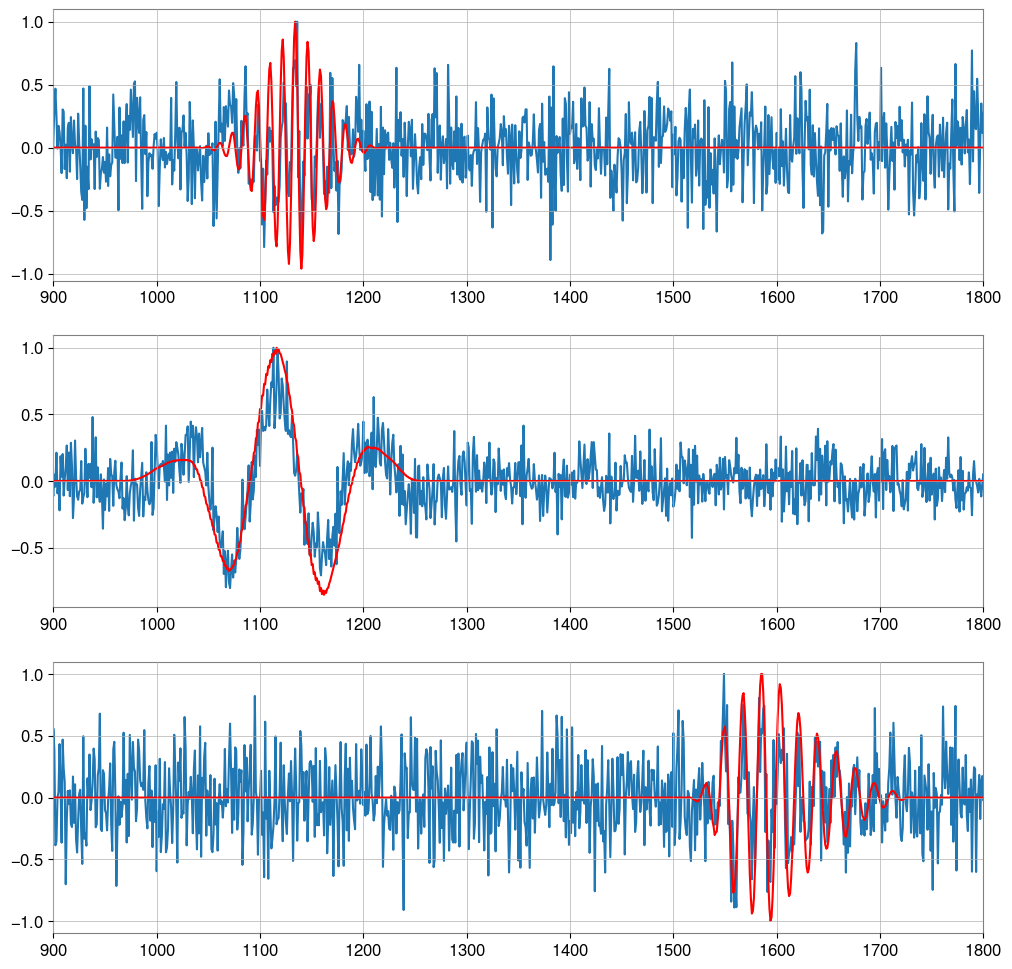

In [29]:
fig, axs = plt.subplots(nrows=3, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.plot(X[i])
    ax.plot(reconstructions[i], color='red')

    ax.set_xlim(900, 1800)

## Iterative denoising

In [24]:
X = strains_injected[[0, 5, 10]]

reconstructions, residuals, iters = dico.reconstruct_iterative_minibatch(
    X.T,
    sc_lambda=0.7,
    step=2,
    batchsize=2,
    max_iter=1000,
    threshold=0.01,
    normed=True,
    full_output=True,
    verbose=False
)

reconstructions = reconstructions.T
residuals = residuals.T


np.savez_compressed(
    'data/_dictionary_spams/reconstructions_iterative.npz',
    input=X,
    target_reconstructions=reconstructions,
    target_residuals=residuals,
    target_iters=iters
)

In [25]:
print(reconstructions.shape)
print(residuals.shape)
print(iters)

(3, 3270)
(3, 3270)
[17 14 18]


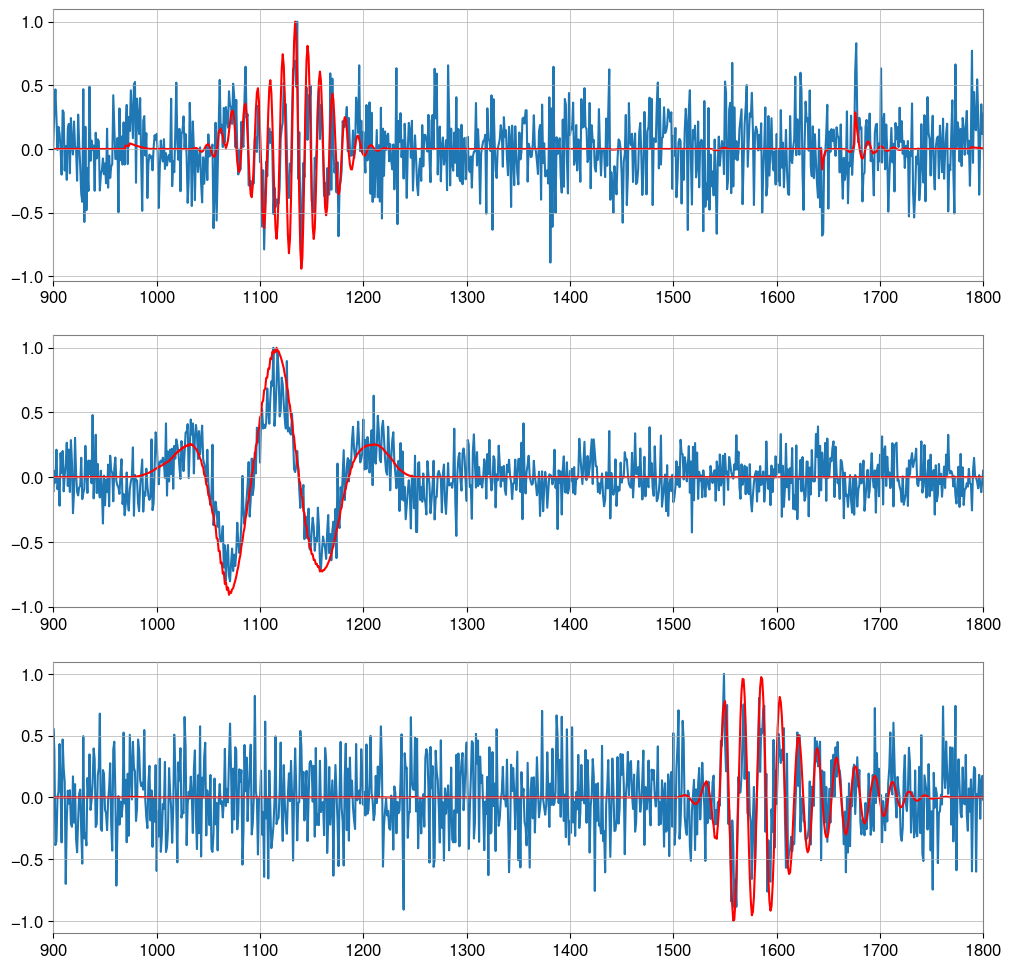

In [26]:
fig, axs = plt.subplots(nrows=3, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.plot(X[i])
    ax.plot(reconstructions[i], color='red')

    ax.set_xlim(900, 1800)

## Reconstruct auto

In [86]:
x = strains_injected[10]

rec, code, result = dico.reconstruct_auto(
    x,
    zero_marg=100,
    lambda_lims=(0.01, 10),
    step=4,
    normed=True,
    full_output=True
)
code=code.toarray()

{'funcalls': 45,
 'converged': True,
 'niters': 43,
 'x': 0.31790233875426344,
 'f': 2.640481907105658e-13}

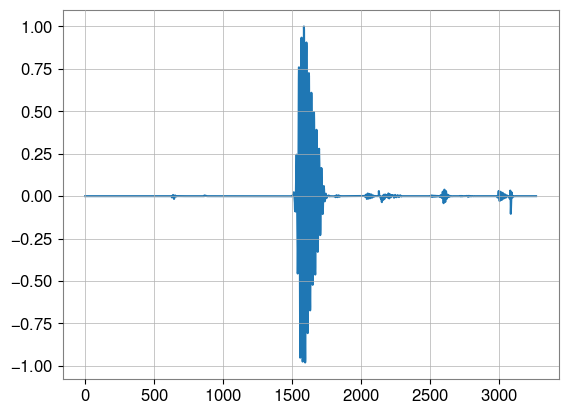

In [87]:
fig, ax = plt.subplots()
ax.plot(rec)
# ax.set_xlim(1450, 1800)

result

In [88]:
np.savez_compressed(
    'data/_dictionary_spams/reconstruct_auto.npz',
    input=x,
    reconstruction=rec,
    code=code,
    result=result
)

In [81]:
f = np.load('data/_dictionary_spams/reconstruct_auto.npz', allow_pickle=True)
f.files

['input', 'reconstruction', 'code', 'result']

In [82]:
f['result'].item()

{'funcalls': 45,
 'converged': True,
 'niters': 43,
 'x': 912.0,
 'f': 2.640481907105658e-13}

## Optimum reconstruct

In [6]:
i = 10
x0 = strains_clean[i][:wave_pos_clean[i,1]]  # Do not crop the beginning!
x = strains_injected[i][:lengths_injected[i]]

# Add margin to clean signal equivalent to that added to the injected one.
pad0, r = divmod(len(x)-len(x0), 2)
pad1 = pad0 + r

limits = [pad0, pad0+len(x0)]

x0 = np.pad(x0, (pad0, pad1))

(1024.0, 2065.0)

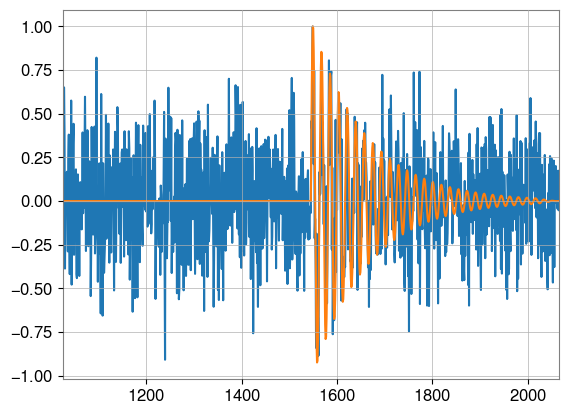

In [7]:
fig, ax = plt.subplots()
ax.plot(x)
ax.plot(x0)
ax.set_xlim(*limits)

In [8]:
rec, l_opt, loss = dico.optimum_reconstruct(
    x,
    reference=x0,
    kwargs_minimize={},
    kwargs_lasso={},
    step=2,
    limits=limits,
    normed=True
)

print(l_opt, loss)

0.13802512907885497 -0.9047413879391225


(1024.0, 2065.0)

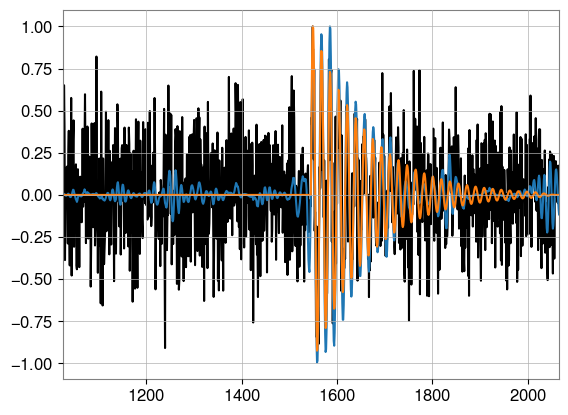

In [9]:
fig, ax = plt.subplots()
ax.plot(x, color='black')
ax.plot(rec)
ax.plot(x0)
ax.set_xlim(*limits)

In [18]:
np.savez_compressed(
    'data/_dictionary_spams/optimum_reconstruct.npz',
    input=x,
    reference=x0,
    limits=limits,
    reconstruction=rec,
    l_opt=l_opt,
    loss=loss
)

In [11]:
f = np.load('data/_dictionary_spams/optimum_reconstruct.npz')
f.files

['input', 'reference', 'reconstruction', 'l_opt', 'loss']

In [17]:
f['l_opt'].item()

0.13802512907885497

# Extract patches (func)

In [3]:
parametrized_tests = []

## Split single signal (windowing)

- with patch size 64, 65, len(signal).
- with steps 4, 5, len(signal).
- with and without l2 normalization.
- with normalization coefficients.
- with its length being odd.

Create the signal.

Text(0.5, 1.0, 'length = 724')

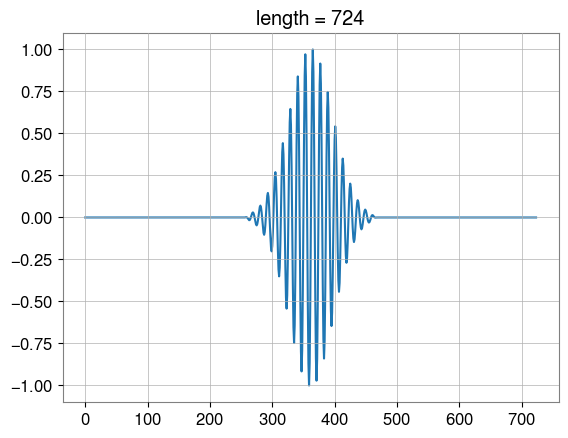

In [4]:
x = strains_clean[0,slice(*wave_pos_clean[0])]
x = np.pad(x, (256, 256))

fig, ax = plt.subplots()
ax.plot(x)
ax.set_title(f"length = {len(x)}")

(42, 64)
-1.0
1.0


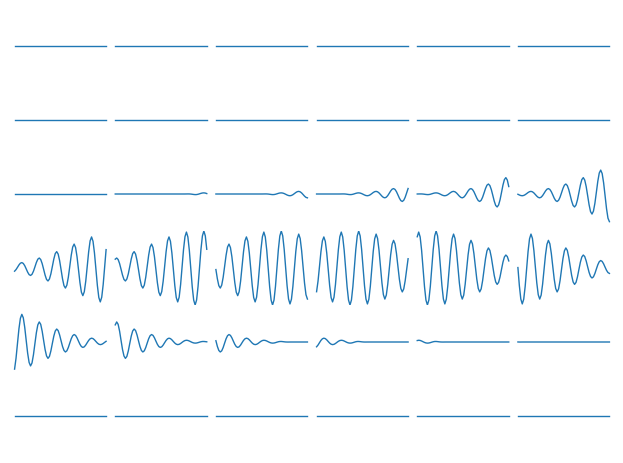

In [25]:
# Split signal with different steps.
params = dict(
    patch_size=64,
    n_patches=None,
    random_state=None,
    step=16,
    limits=None,
    patch_min=1,
    l2_normed=False,
    return_norm_coefs=False,
    allow_allzeros=False
)
Y = clawdia.lib.extract_patches(x[:-1], **params)
Y = Y.T

print(Y.shape)
print(Y.min())
print(Y.max())
# print(coefs)

clawdia.plotting.plot_dictionary(Y.T, c=6, ylim=(-1, 1));

In [26]:
parametrized_tests.append([
    "input,params,target",
    [x, params, Y]
])

In [27]:
aux = []
for i in range(len(parametrized_tests)):
    aux.append(parametrized_tests[i][1][1])
pd.DataFrame(aux)

,patch_size,n_patches,random_state,step,limits,patch_min,l2_normed,return_norm_coefs,allow_allzeros
0,64,None,None,16,None,1,False,False,True
1,65,None,None,16,None,1,False,False,True
2,724,None,None,16,None,1,False,False,True
3,64,None,None,17,None,1,False,False,True
4,64,None,None,64,None,1,False,False,True
5,64,None,None,128,None,1,False,False,True
6,64,None,None,16,None,1,True,False,True
7,64,None,None,16,None,1,True,True,True
8,64,None,None,16,None,1,False,False,False


## Extract random patches (signal pool)

- Extract N patches.
- Extract All patches.
- Try to extract more patches than available.
- with and without l2 normalization.
- allow and do not allow allzeros.
- with and without limits.
- with and without patch_min (case with limits).

(15, 2048)


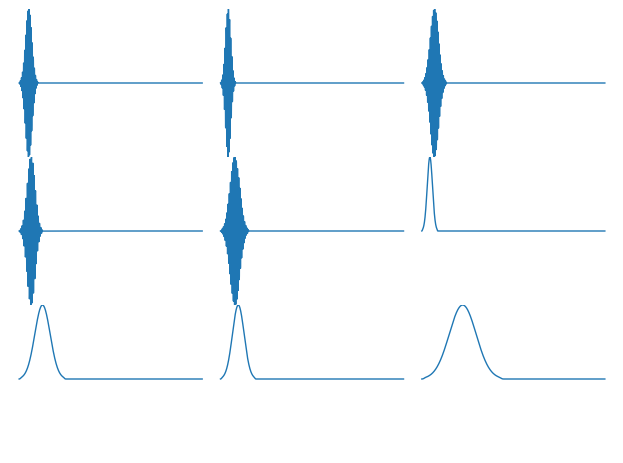

In [28]:
X = strains_clean.copy()
print(X.shape)

clawdia.plotting.plot_dictionary(X.T, ylim=(-1, 1));

(100, 64)
-0.4816975444399741
0.35921256912098226


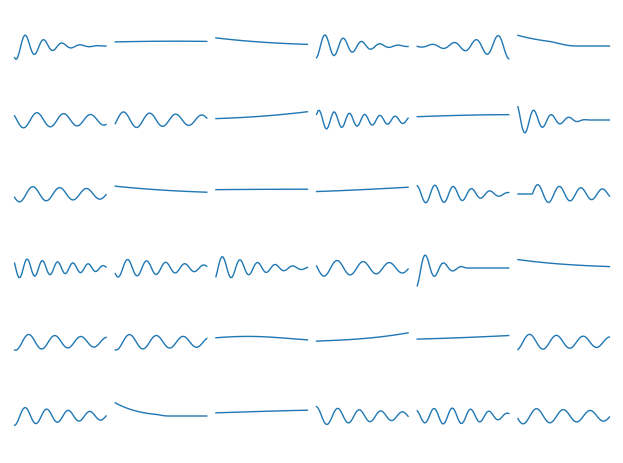

In [42]:
# Split signal with different steps.
params = dict(
    patch_size=64,
    n_patches=100,
    random_state=42,
    step=1,
    limits=wave_pos_clean,
    patch_min=32,
    l2_normed=True,
    return_norm_coefs=True,
    allow_allzeros=False
)
Y, coefs = clawdia.lib.extract_patches(X.T, **params)
Y = Y.T

print(Y.shape)
print(Y.min())
print(Y.max())
# print(coefs)

clawdia.plotting.plot_dictionary(Y.T, c=6, ylim=(-1, 1));

In [43]:
parametrized_tests.append([
    "input,params,target",
    [X, params, (Y, coefs)]
])

**UNTIL I FIGURE OUT HOW TO PROPERLY SAVE THE PARAMETER SEQUENCE, PICKLE IT**

In [48]:
import pickle
with open('data/lib/parametrized_tests.pkl', 'wb') as f:
    pickle.dump(parametrized_tests, f, pickle.HIGHEST_PROTOCOL)

In [3]:
# load the temporarily saved parametrized tests
import pickle
with open('data/lib/parametrized_tests.pkl', 'rb') as f:
    parametrized_tests = pickle.load(f)

In [15]:
parametrized_tests[0][1][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
# I will store all parameters in a compressed numpy file, but input and outputs
# will be stored on individual files since they change shapes.

n_tests = len(parametrized_tests)
f_input = 'data/lib/extract_patches/input_test-{}.npz'
f_parameters = 'data/lib/extract_patches/parameters_all_tests.npz'
f_target = 'data/lib/extract_patches/target_test-{}.npz'


parametrized_tests_np = {
    'patch_size':        np.zeros(n_tests, dtype=int),
    'n_patches':         np.zeros(n_tests, dtype=int),
    'random_state':      np.zeros(n_tests, dtype=int),
    'step':              np.zeros(n_tests, dtype=int),
    'limits':            np.zeros((n_tests, *wave_pos_clean.shape), dtype=int),
    'patch_min':         np.zeros(n_tests, dtype=int),
    'l2_normed':         np.zeros(n_tests, dtype=bool),
    'return_norm_coefs': np.zeros(n_tests, dtype=bool),
    'allow_allzeros':    np.zeros(n_tests, dtype=bool)
}


# Build parameters and save input/target at same time.
for i_test in range(n_tests):
    np.savez_compressed(
        f_input.format(i_test),
        input=parametrized_tests[i_test][1][0]
    )

    for key in parametrized_tests_np:
        value = parametrized_tests[i_test][1][1][key]

        if value is None:
            value = -1

        parametrized_tests_np[key][i_test] = value
    
    target = parametrized_tests[i_test][1][2]  # Can be Y or (Y, coefs)
    if isinstance(target, tuple):
        np.savez_compressed(
            f_target.format(i_test),
            target_Y=target[0],
            target_coefs=target[1]
        )
    elif isinstance(target, np.ndarray):
        np.savez_compressed(
            f_target.format(i_test),
            target_Y=target
        )
    else:
        raise RuntimeError("WUT?")
    
# Save parameters
np.savez_compressed(f_parameters, **parametrized_tests_np)

In [35]:
i_test = 9
for k, v in parametrized_tests_np.items():
    print(k, v[i_test])

patch_size 64
n_patches 100
random_state 42
step 1
limits [[-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]]
patch_min 1
l2_normed False
return_norm_coefs False
allow_allzeros True
